<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100K ie S2 events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd
import h5py


import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

# Functions

In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)


In [3]:
def read_fiber_sens(file_path):
    """
    Read an HDF5 file using pd.read_hdf() with an optional condition.

    Parameters:
    - file_path (str): The path to the HDF5 file.

    Returns:
    - DataFrame: The loaded DataFrame.
    """

    sns_positions = pd.read_hdf(file_path, "/MC/sns_positions", where='sensor_name == F_SENSOR')
    sns_response = pd.read_hdf(file_path, "/MC/sns_response")


    sns_response = sns_response.loc[sns_response.sensor_id.isin(sns_positions.sensor_id)] # get the positions of said sensors


    return sns_positions, sns_response

In [4]:
def offline_s2_max_dict(file_path): 
    # Max value of the s2 signals 
    # Load the 3D dictionary from the HDF5 file

    columns = {0:'time',
               1:'s2'
              }

    bin_width = 1000 # [ns] = 1 [us]
    s2_max_dict = {} # s2 peak per sensor
    full_s2_max_dict = {} # s2 peak per event

    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as file:
        # Iterate through the top-level keys (groups) in the HDF5 file
        for key in file.keys():
            # Get the group corresponding to the current key
            group = file[key]
            full_s2 = []

            # Print the top-level key
            print(f'Top-level key: {key}')

            # Iterate through the subkeys (datasets) in the current group
            for subkey in group.keys():

                # Check if subkey is already in the dictionary
                if subkey not in s2_max_dict:
                    s2_max_dict[subkey] = []

                # Get and print the value corresponding to the current subkey
                signal = group[subkey][()]
                signal = pd.DataFrame(signal)
                signal.rename(columns = columns, inplace=True)

                t = signal.time
                s2 = signal.s2
                binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

                # Create a histogram
                hist_values, bin_edges = np.histogram(t, bins=binin,
                                                      weights = s2)

    #             print(f'Subkey: {subkey}, Value: {value}')

                full_s2.append(hist_values.max()) # peak of s2 signal
                s2_max_dict[subkey].append(hist_values.max()) # peak of s2 signal

            full_s2_max_dict[key] = max(full_s2)
            
    return full_s2_max_dict, s2_max_dict
            


In [5]:
def offline_s2_waveform(filename, event, sensor, bin_width_in_us = 1, new_figure = True, comment = ''):
    
    if new_figure:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True) # Create a new figure
    
    else:
        # Check if there's an existing figure and create it if there's none
        if plt.gcf().get_axes():
            ax = plt.gcf().get_axes()[0]
        else:
            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True) 
    
    font_size = 15
    ev = f'{event}'
    sens = f'sens_{sensor}'
    
    columns = {0:'time',
               1:'s2'
              }
    

    # Open the HDF5 file in read mode
    with h5py.File(filename, 'r') as file:

        # Get the group corresponding to the current key
        group = file[ev]
    
        if sensor == all:
            
            # Get a list of all keys (sensor names) in the group
            sensor_keys = list(group.keys())

            # Use list comprehension to get all datasets (signals) for all sensors in the group
            all_signals = [group[sensor_key][()] for sensor_key in sensor_keys]

            # Convert the list of signals to a DataFrame
            signal = pd.DataFrame(np.concatenate(all_signals))

            # Assuming 'columns' is defined elsewhere in your code
            signal.rename(columns=columns, inplace=True)
            
            sens = 'all sensors'


        else:
            
            # Get and print the value corresponding to the current subkey
            signal = group[sens][()]
            signal = pd.DataFrame(signal)
            signal.rename(columns = columns, inplace=True)


    t = signal.time*1e-3 # [us]
    s2 = signal.s2 # [e]

    bin_width = bin_width_in_us # time units ([us])

    binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

    events, bins, bars = ax.hist(t, binin, 
                                 weights = s2,
                                 density=False,
#                                  histtype='step',
                                 histtype='stepfilled',
                                 alpha = 0.5,
                                 label = f'Offline s2 of event {ev} in {sens} (using maps) {comment}'
                                )
    ax.set_title(f's2 of event {ev} in {sens}', fontsize = font_size);
    ax.set_xlabel('Time [us]', fontsize = font_size);
    ax.set_ylabel('Signal [e]', fontsize = font_size);

    ax.tick_params(axis='both', labelsize = font_size*2/3)
    
    return events, bins, ax
    
            


In [6]:
def online_s2_waveform(filename, event, sensor, bin_width_in_us = 1, new_figure = True, comment = ''):
    
    font_size = 15
    ev = event
    sens = sensor
    
    if new_figure:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True) # Create a new figure
    
    else:
        # Check if there's an existing figure and create it if there's none
        if plt.gcf().get_axes():
            ax = plt.gcf().get_axes()[0]
        else:
            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True) 

    if sensor == all:
        online_signal = sns_response.loc[(sns_response.event_id == ev)].copy()
        sens = 'all sensors'
        
        
    else:
        online_signal = sns_response.loc[(sns_response.event_id == ev) &
                                         (sns_response.sensor_id == sens)].copy()

    online_signal.time_bin = online_signal.time_bin*t_binning # [ns]
        
    tt = online_signal.time_bin*1e-3 # [us]
    online_s2 = online_signal.charge # [e]

    t_window_min = 400 # [us]
    t_window_max = 1000 # [us]

    t_window = (t_window_min < tt) & (tt < t_window_max)

    on_t = tt[t_window]
    online_s2 = online_s2[t_window]


    bin_width = bin_width_in_us # time units ([us])

    on_binin = np.arange(on_t.min() - bin_width, on_t.max() + 2*bin_width, bin_width)

    events, bins, bars = ax.hist(on_t, on_binin, 
                                 weights = online_s2,
                                 density=False,
                                 histtype='step',
                                 label = f'Online s2 of event {0} in {sens} (simulation readout) {comment}'
                                )

    ax.set_title(f's2 waveform for sensor {sens}', fontsize = font_size);
    ax.set_xlabel('Time [us]', fontsize = font_size);
    ax.set_ylabel('Signal [e]', fontsize = font_size);

    ax.tick_params(axis='both', labelsize = font_size*2/3)

    return events, bins, ax
    


# Reading the file

In [7]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

# off_s2_filename = os.path.join(path, "bb0nu_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20231215_bb0nu_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20231218_bb0nu_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20231220_bb0nu_100ev_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20231226_bb0nu_100ev_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20240109_bb0nu_100ev_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20240113_bb0nu_200ev_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20240122_bb0nu_1fullev_s2_signal.h5")
# off_s2_filename = os.path.join(path, "20240206_bb0nu_1fullev_s2_signal.h5")

# off_s2_filename = os.path.join(path, "20240213_bb0nu_1fullev_s2_signal.h5") # has fluctuations
# off_s2_filename_no_fluct = os.path.join(path, "20240206_bb0nu_1fullev_s2_signal.h5") # no fluctuations

off_s2_filename = os.path.join(path, "20240219_bb0nu_200ev_s2_signal.h5") # has fluctuations


In [8]:
with tb.open_file(off_s2_filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/20240219_bb0nu_200ev_s2_signal.h5 (File) ''
Last modif.: '2024-02-19T18:46:05+00:00'
Object Tree: 
/ (RootGroup) ''
/0 (Group) ''
/0/sens_200 (Array(108477, 2)) ''
/0/sens_201 (Array(108477, 2)) ''
/0/sens_202 (Array(108477, 2)) ''
/0/sens_203 (Array(108477, 2)) ''
/0/sens_204 (Array(108477, 2)) ''
/0/sens_205 (Array(108477, 2)) ''
/0/sens_206 (Array(108477, 2)) ''
/0/sens_207 (Array(108477, 2)) ''
/0/sens_208 (Array(108477, 2)) ''
/0/sens_209 (Array(108477, 2)) ''
/0/sens_210 (Array(108477, 2)) ''
/0/sens_211 (Array(108477, 2)) ''
/0/sens_212 (Array(108477, 2)) ''
/0/sens_213 (Array(108477, 2)) ''
/0/sens_214 (Array(108477, 2)) ''
/0/sens_215 (Array(108477, 2)) ''
/0/sens_216 (Array(108477, 2)) ''
/0/sens_217 (Array(108477, 2)) ''
/0/sens_218 (Array(108477, 2)) ''
/0/sens_219 (Array(108477, 2)) ''
/0/sens_220 (Array(108477, 2)) ''
/0/sens_221 (Array(108477, 2)) ''
/0/sens_222 (Array(108477, 2)) ''
/0/sens_223 (Arra

In [9]:
full_s2_max_dict, s2_max_dict = offline_s2_max_dict(off_s2_filename)

Top-level key: 0
Top-level key: 1
Top-level key: 10
Top-level key: 100
Top-level key: 101
Top-level key: 102
Top-level key: 103
Top-level key: 104
Top-level key: 105
Top-level key: 106
Top-level key: 107
Top-level key: 108
Top-level key: 109
Top-level key: 11
Top-level key: 110
Top-level key: 111
Top-level key: 112
Top-level key: 113
Top-level key: 114
Top-level key: 115
Top-level key: 116
Top-level key: 117
Top-level key: 118
Top-level key: 119
Top-level key: 12
Top-level key: 120
Top-level key: 121
Top-level key: 122
Top-level key: 123
Top-level key: 124
Top-level key: 125
Top-level key: 126
Top-level key: 127
Top-level key: 128
Top-level key: 129
Top-level key: 13
Top-level key: 130
Top-level key: 131
Top-level key: 132
Top-level key: 133
Top-level key: 134
Top-level key: 135
Top-level key: 136
Top-level key: 137
Top-level key: 138
Top-level key: 139
Top-level key: 14
Top-level key: 140
Top-level key: 141
Top-level key: 142
Top-level key: 143
Top-level key: 144
Top-level key: 145
To

In [10]:
off_s2_filename

'/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/20240219_bb0nu_200ev_s2_signal.h5'

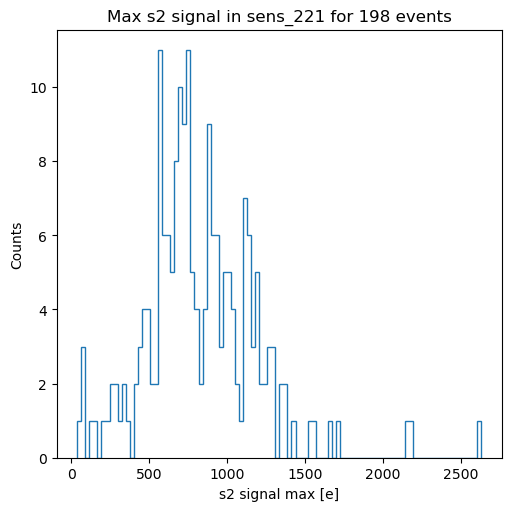

In [12]:
sensor = 'sens_221'

s2 = s2_max_dict[sensor]
s2 = np.array(s2)
n_events = np.size(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 100
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 8.5

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2', 
                             histtype='step')

ax.set_title(f'Max s2 signal in {sensor} for {n_events} events');
ax.set_xlabel('s2 signal max [e]');
ax.set_ylabel('Counts');


<h1> __________________________ </h1>
<h2> Global parameters </h2>

In [13]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe

n_sensors = 90 

t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Files </h2>

In [14]:
path = '/home/investigator/mariandbt/python/data/'
path = path + '/20231025_NEXT100_full_mapping/next100_fibers'

online_s2_filename = os.path.join(path, "20240122_Next100_bb_1.next.h5") # 1 full bb w s2

In [15]:
with tb.open_file(online_s2_filename) as file:
    print(file)

/home/investigator/mariandbt/python/data//20231025_NEXT100_full_mapping/next100_fibers/20240122_Next100_bb_1.next.h5 (File) ''
Last modif.: '2024-01-24T09:19:06+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(47,)) ''
/MC/hits (Table(786,)) ''
/MC/particles (Table(101386,)) ''
/MC/sns_positions (Table(3431,)) ''
/MC/sns_response (Table(2615102,)) ''



In [16]:
sns_positions, sns_response = read_fiber_sens(online_s2_filename)

/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/io/pytables.py:3523: IncompatibilityWarning: 
where criteria is being ignored as this version [0.0.0] is too old (or
not-defined), read the file in and write it out to a new file to upgrade (with
the copy_to method)

  warnings.warn(ws, IncompatibilityWarning)


In [17]:
dst_fibers = sns_response.copy()
dst_fibers.time_bin = dst_fibers.time_bin*t_binning

In [18]:
sens = 240
dst_onesens = dst_fibers.loc[dst_fibers.sensor_id == sens]

In [19]:
dst_onesens

event_id  sensor_id  time_bin  charge
782783         0        240      34.7       1
782784         0        240      70.8       1
782785         0        240      74.5       1
782786         0        240      74.8       1
782787         0        240      87.3       1
...          ...        ...       ...     ...
801349         0        240  687722.0       1
801350         0        240  688551.6       1
801351         0        240  688565.3       1
801352         0        240  688868.9       1
801353         0        240  689761.0       1

[18571 rows x 4 columns]

<h1> __________________________ </h1>
<h2> Analysis </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reconstructed offline s2 waveform </b> </p>

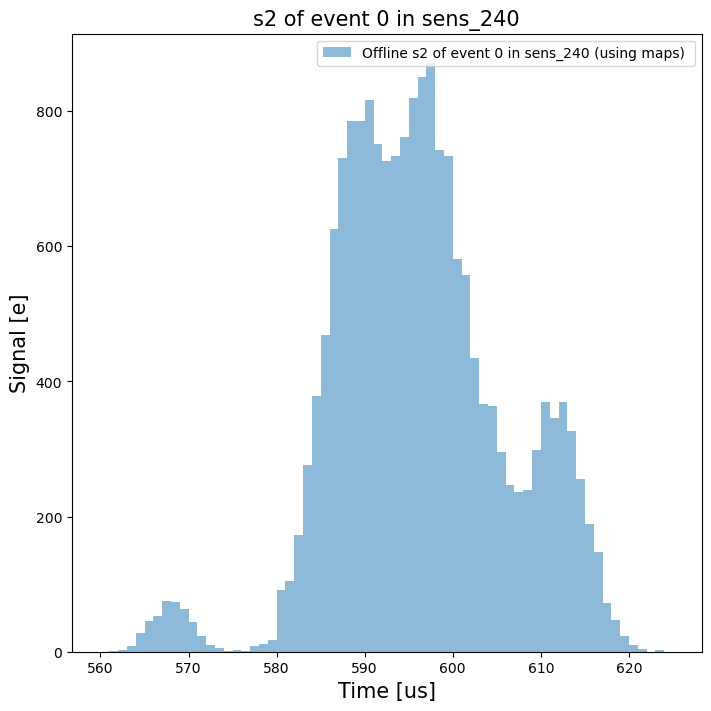

In [20]:
_, _, ax = offline_s2_waveform(off_s2_filename, 0, sens, new_figure = True)
# offline_s2_waveform(off_s2_filename, 0, all, new_figure = False)
ax.legend()

-  <p style="font-size: 17px; color: black;"> <b> Direct online s2 waveform </b> </p>

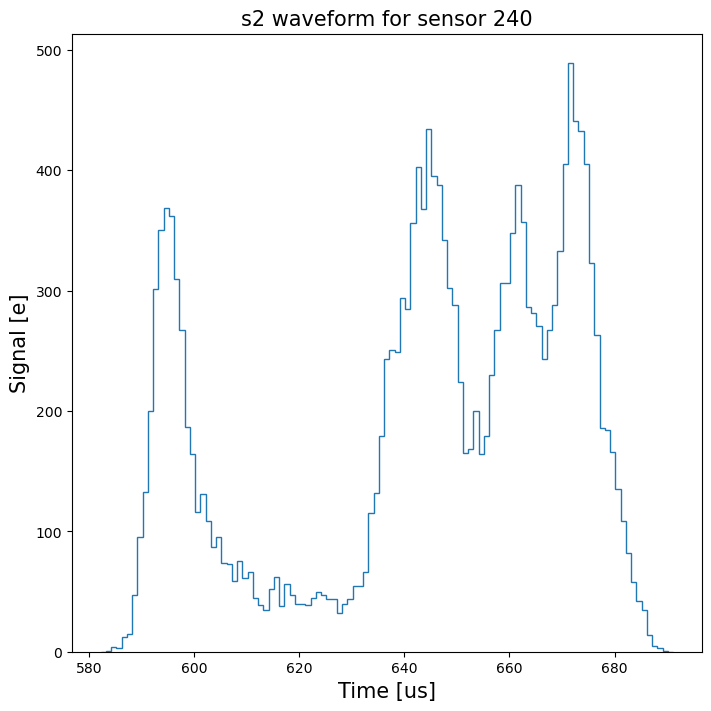

In [21]:
_, _, _ = online_s2_waveform(online_s2_filename, 0, sens, new_figure = True)

-  <p style="font-size: 17px; color: black;"> <b> Both s2 waveform </b> </p>

In [22]:
sens = all
bin_width = 1 # [us]

NameError: name 'off_s2_filename_no_fluct' is not defined

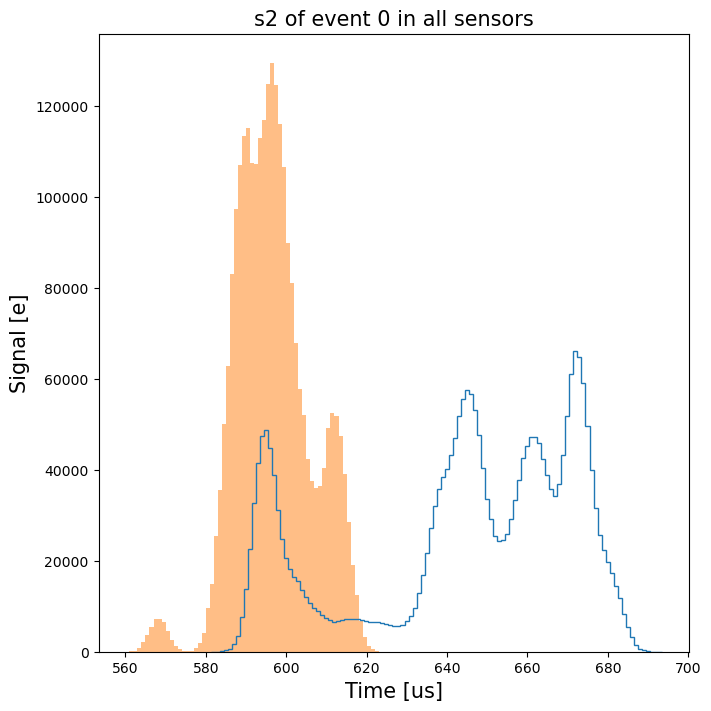

In [23]:
on_events, on_bins, ax = online_s2_waveform(online_s2_filename, 0, sens, bin_width, new_figure = True)

off_events, off_bins, _ = offline_s2_waveform(off_s2_filename, 0, sens, bin_width, new_figure = False,  comment = '- w fluctuations')

off_no_fluct_events, off_no_fluct_bins, _ = offline_s2_waveform(off_s2_filename_no_fluct, 0, sens, bin_width, new_figure = False, comment = '- w/o fluctuations')

ax.legend()


In [ ]:
# Calculate the middle points of the bins
on_bin_centers = 0.5 * (on_bins[:-1] + on_bins[1:])
off_bin_centers = 0.5 * (off_bins[:-1] + off_bins[1:])
off_no_fluct_bin_centers = 0.5 * (off_no_fluct_bins[:-1] + off_no_fluct_bins[1:])


In [ ]:
on_mean = (on_bin_centers*on_events/on_events.sum()).mean()
off_mean = (off_bin_centers*off_events/off_events.sum()).mean()
off_no_fluct_mean = (off_no_fluct_bin_centers*off_no_fluct_events/off_no_fluct_events.sum()).mean()

delay = on_mean - off_mean
delay_no_fluct = on_mean - off_no_fluct_mean


In [ ]:
delay, delay_no_fluct

In [ ]:
on_mean, off_mean, off_no_fluct_mean

In [ ]:
on_x_ax[on_peaks] - off_x_ax[off_peaks]

In [ ]:
from scipy.signal import find_peaks



on_events, on_bins, ax = online_s2_waveform(online_s2_filename, 0, sens, new_figure = True)

off_events, off_bins, _ = offline_s2_waveform(off_s2_filename, 0, sens, new_figure = False,  comment = '- w fluctuations')




height_min = 4e4 # height threshold to which consider a peak
dist_min = 10. # min distance between peaks required
dif_min = None # min height difference between the peak point and their neighbours 

on_peaks, _ = find_peaks(on_events, height=height_min, threshold=dif_min, distance=dist_min)
on_x_ax = on_bin_centers

off_peaks, _ = find_peaks(off_events, height=height_min, threshold=dif_min, distance=dist_min)
off_x_ax = off_bin_centers

delay = (on_x_ax[on_peaks] - off_x_ax[off_peaks]).mean()



ax.plot(on_x_ax[on_peaks], on_events[on_peaks], 'o', label = 'Identified online peaks')
ax.plot(x_ax, height_min*np.ones(len(x_ax)), label = 'Minimum height considered for a peak')
ax.plot(off_x_ax[off_peaks], off_events[off_peaks], 'o', label = 'Identified offline peaks')



ax.text(0.05, .9, f' delay = {delay} [us]', transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.legend()

In [ ]:
len(h5py.File(off_s2_filename, 'r').keys())

In [ ]:
filename = off_s2_filename

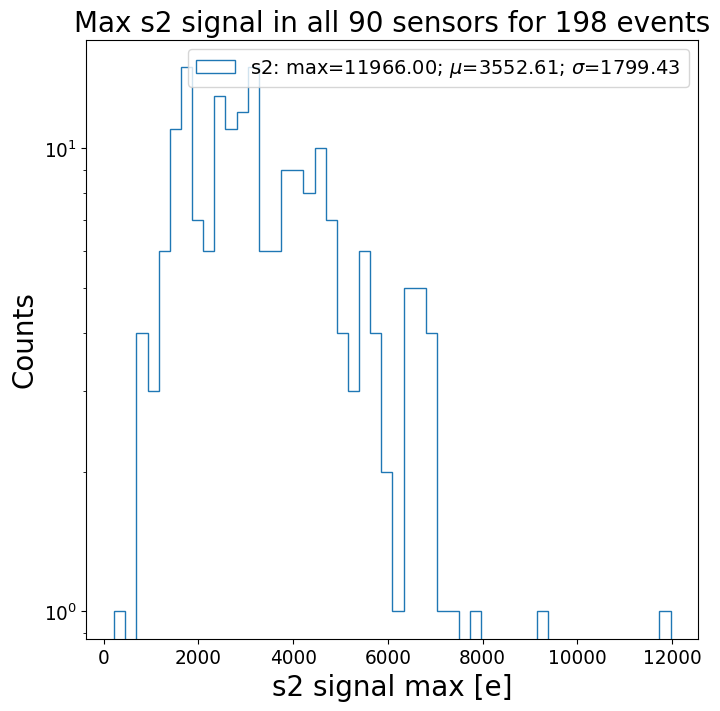

In [24]:
# s2 = np.array(list(s2_max_dict.values()))
s2 = np.array(list(full_s2_max_dict.values()))

n_events = np.shape(s2)[0]
# n_events = np.shape(s2)[1]
n_sensors = 90

# s2 = np.concatenate(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7,7), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 50
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 20

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2: max=%.2f; $\mu$=%.2f; $\sigma$=%.2f'%(s2.max(), s2.mean(), s2.std()), 
                             histtype='step')

ax.set_title(f'Max s2 signal in all {n_sensors} sensors for {n_events} events', fontsize = font_size);
ax.set_xlabel('s2 signal max [e]', fontsize = font_size);
ax.set_ylabel('Counts', fontsize = font_size);
ax.set_yscale('log')

ax.legend(fontsize=0.7*font_size, loc='best')

ax.tick_params(axis='both', labelsize = font_size*2/3)

Text(0, 0.5, 'Frequency')

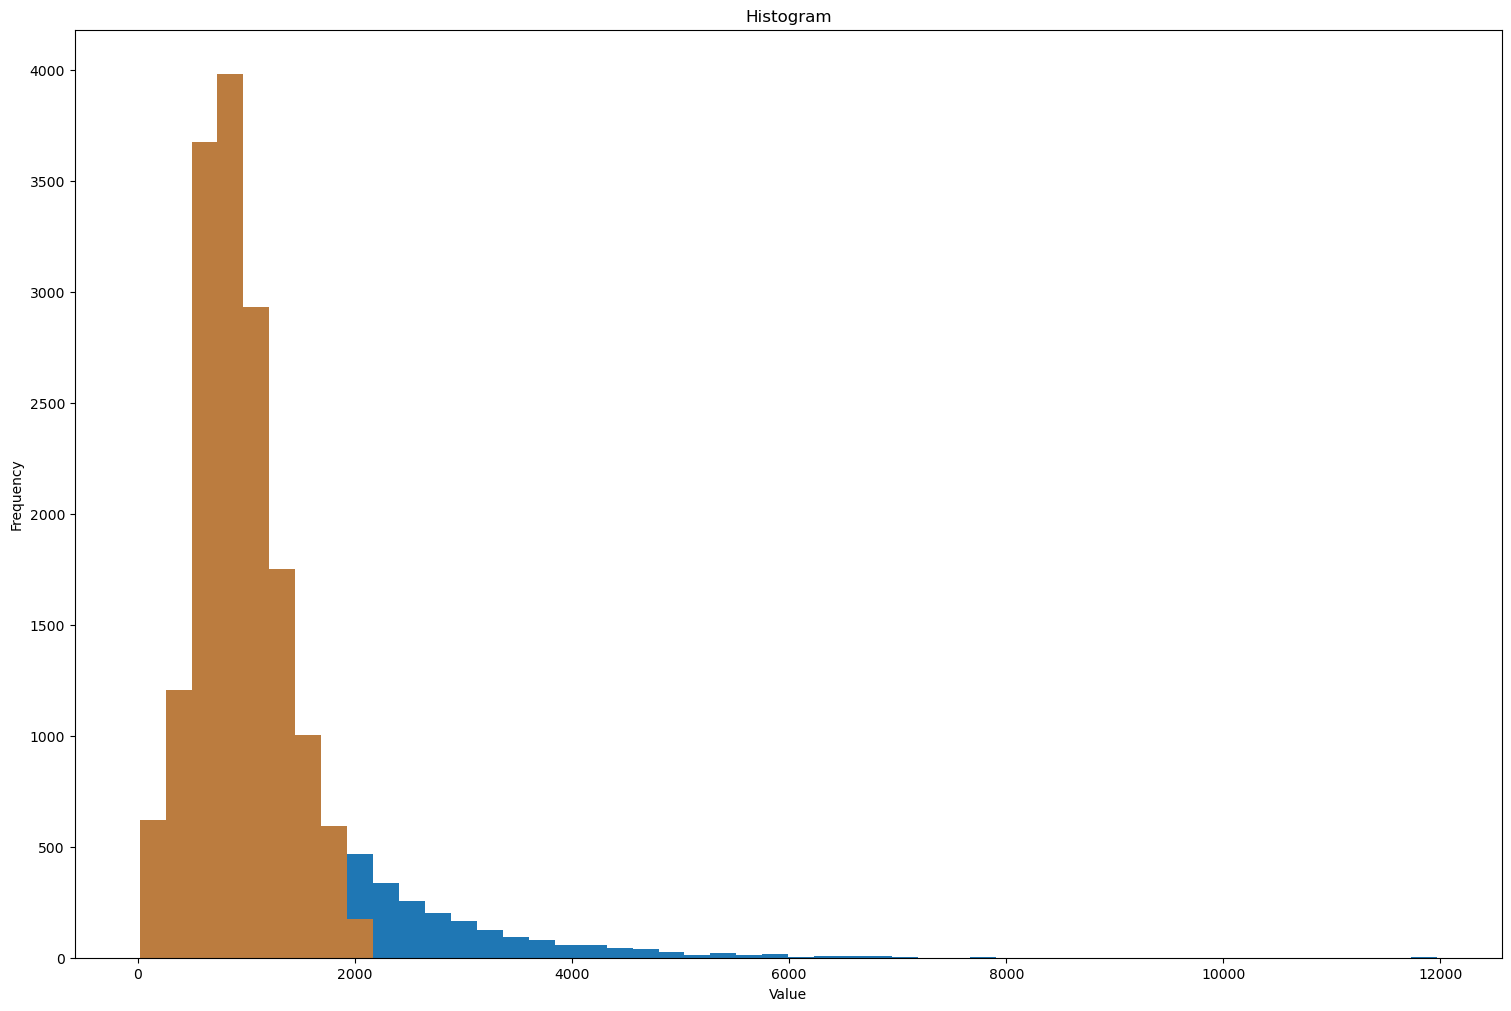

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,10), constrained_layout=True)

s2 = np.array(list(s2_max_dict.values()))
s2 = np.concatenate(s2)

# Create a histogram
events, bin_ref = np.histogram(s2, bins=binin)

# Plot the histogram
ax.hist((bin_ref[1:] + bin_ref[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=1)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

s2 = s2[s2 < 2000]
events, bins = np.histogram(s2, bins=bin_ref)
ax.hist((bins[1:] + bins[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=0.7)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

ax.set_title('Histogram')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')


In [26]:
# s2 = np.array(list(s2_max_dict.values()))
# s2 = np.concatenate(s2)
s2 = np.array(list(full_s2_max_dict.values()))

# Create a histogram
events_ref, bin_ref = np.histogram(s2, bins=binin)

cuts = np.arange(s2.max(), s2.min(), -500)
eff_dict = {}

for ii, cut in enumerate(cuts):
    
    s2 = s2[s2 < cut]
    events, bins = np.histogram(s2, bins=bin_ref)
    
    eff = events.sum()*100/events_ref.sum()
    
    eff_dict[cut] = eff
    


In [27]:
# eff_dict

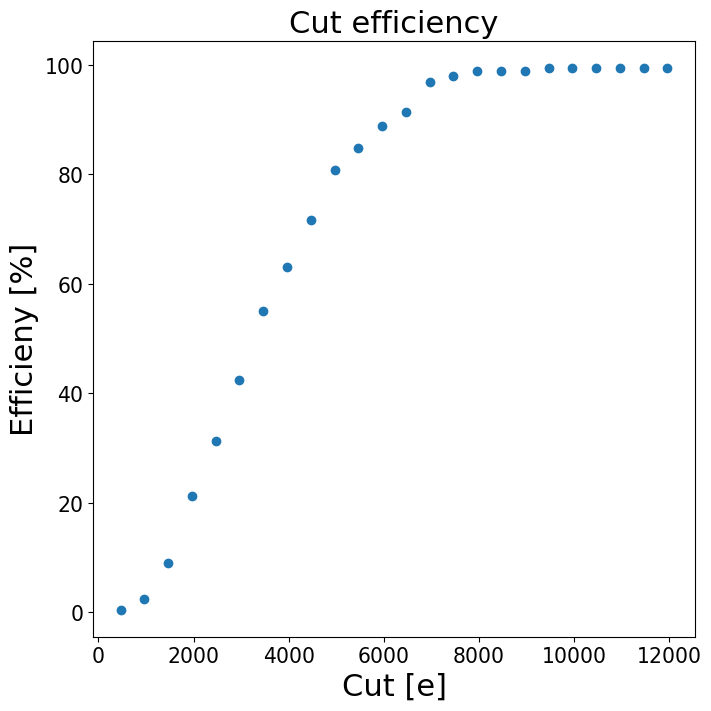

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
font_size = 22

ax.plot(eff_dict.keys(), eff_dict.values(), 'o')
ax.set_title('Cut efficiency', fontsize = font_size)
ax.set_ylabel('Efficieny [%]', fontsize = font_size)
ax.set_xlabel('Cut [e]', fontsize = font_size)

ax.tick_params(axis='both', labelsize = font_size*2/3)
# ax.tick_params(axis='y', labelsize = font_size)
